In [ ]:
from __future__ import division

import numpy as np 
from numpy.linalg import multi_dot
from scipy.spatial import ConvexHull ###Import the Convex hull construction function
#from scipy.special import expn
from scipy.integrate import quad
from scipy.optimize import curve_fit


import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import math
import matplotlib
import matplotlib.colors as colors
matplotlib.rcParams['text.usetex'] = True

In [2]:
def non_equisp_grid(phi_min, phi_max, n_points, phi_log_min, phi_power, n_log_points):
    
    span = np.linspace(phi_min, phi_max, n_points)
    center = (phi_max+phi_min)/2
    
    log_span_in = np.logspace(-phi_power,-1,n_log_points) + phi_log_min
    log_span_fin = 2*center -log_span_in
    
    span = np.concatenate((log_span_in, span, log_span_fin))
    
    return span[np.argsort(span)]

In [3]:
#INTERCEPTION BETWEEN TWO CURVES

def _rect_inter_inner(x1,x2):
    n1=x1.shape[0]-1
    n2=x2.shape[0]-1
    X1=np.c_[x1[:-1],x1[1:]]
    X2=np.c_[x2[:-1],x2[1:]]
    S1=np.tile(X1.min(axis=1),(n2,1)).T
    S2=np.tile(X2.max(axis=1),(n1,1))
    S3=np.tile(X1.max(axis=1),(n2,1)).T
    S4=np.tile(X2.min(axis=1),(n1,1))
    return S1,S2,S3,S4

def _rectangle_intersection_(x1,y1,x2,y2):
    S1,S2,S3,S4=_rect_inter_inner(x1,x2)
    S5,S6,S7,S8=_rect_inter_inner(y1,y2)

    C1=np.less_equal(S1,S2)
    C2=np.greater_equal(S3,S4)
    C3=np.less_equal(S5,S6)
    C4=np.greater_equal(S7,S8)

    ii,jj=np.nonzero(C1 & C2 & C3 & C4)
    return ii,jj

def intersection(x1,y1,x2,y2):
    """
    INTERSECTIONS Intersections of curves.
    Computes the (x,y) locations where two curves intersect.  The curves
    can be broken with NaNs or have vertical segments.
    """

    ii,jj=_rectangle_intersection_(x1,y1,x2,y2)
    n=len(ii)

    dxy1=np.diff(np.c_[x1,y1],axis=0)
    dxy2=np.diff(np.c_[x2,y2],axis=0)

    T=np.zeros((4,n))
    AA=np.zeros((4,4,n))
    AA[0:2,2,:]=-1
    AA[2:4,3,:]=-1
    AA[0::2,0,:]=dxy1[ii,:].T
    AA[1::2,1,:]=dxy2[jj,:].T

    BB=np.zeros((4,n))
    BB[0,:]=-x1[ii].ravel()
    BB[1,:]=-x2[jj].ravel()
    BB[2,:]=-y1[ii].ravel()
    BB[3,:]=-y2[jj].ravel()

    for i in range(n):
        try:
            T[:,i]=np.linalg.solve(AA[:,:,i],BB[:,i])
        except:
            T[:,i]=np.NaN


    in_range= (T[0,:] >=0) & (T[1,:] >=0) & (T[0,:] <=1) & (T[1,:] <=1)

    xy0=T[2:,in_range]
    xy0=xy0.T
    return xy0[:,0],xy0[:,1]

In [ ]:
class ph_di:

    def __init__(self, kT_range, r, ki, alpha, beta, M, d, plot_param, comp = 'MON', plots = 0):
        
        #ASSIGN SELF.VARIABLES
    
        self.kT_range = kT_range
        
        self.r = r
        self.ki = ki
        self.alpha = alpha
        self.beta = beta
        
        self.M = M
        self.d = d
        
        self.phi_grid_min, n_grid_points, self.phi_min, n_points = plot_param
        self.n_points = int(n_points)
        self.n_grid_points = int(n_grid_points)
        
        self.comp = comp
        self.plots = plots
        
        #DEFINING NEW CLASS OBJECTS
        self.phi_tot_vals = np.linspace(self.phi_min, 1.-self.phi_min, self.n_points)
        
        self.results_mono = [[],[],[]]
        self.results_apparent = [[],[],[]]
    

        self.results_exact = [[],[],[],[],[]]
        
        
        self.results = [[],[],[],[],[]]

        
    
    
    def calc_p1(self, phi, kT):
        phi_star = np.exp((self.alpha/kT - self.beta)-1)
        

        return (1 + 2 *phi/phi_star - np.sqrt(1 + 4 *phi/phi_star) )*phi_star*phi_star/(2*phi)
    
    
    def f_FH(self, phi, kT):
        return np.log(phi)*phi/self.r + (1-phi)*np.log(1-phi) + self.ki/kT*phi*(1-phi)
    
    
    def f_FH_apparent(self, phi, kT):
        phi_st = np.exp((self.alpha/kT - self.beta)-1)
        p1_pst = (1 + 2 *phi/phi_st - np.sqrt(1 + 4 *phi/phi_st) )*phi_st/(2*phi)
        
        r_app = self.r * phi/phi_st * (1-p1_pst)/p1_pst
        
        return np.log(phi)*phi/r_app + (1-phi)*np.log(1-phi) + self.ki/kT*phi*(1-phi)
    
    def f_cl_exact(self, phi, kT):
        #EXACT MEANS FOR d=1 AND M->INFTY
        phi_star = np.exp((self.alpha/kT - self.beta)-1)
        

        p1_pst = (1 + 2 *phi/phi_star - np.sqrt(1 + 4 *phi/phi_star) )*phi_star/(2*phi)
        return (phi*np.log(p1_pst) - phi_star*p1_pst/(1-p1_pst) )/self.r +  (1-phi)*np.log(1-phi) + self.ki/kT*phi*(1-phi)
    
    
    def convex_hull( self, phis, fs ):
    
        max_f = np.amax(fs)

        hull=np.zeros((len(phis) + 2, 2))

        hull[0] = np.append( 0, max_f +1 ) 
        hull[1] = np.append( 1, max_f +1 ) 

        hull[2:,0] = phis
        hull[2:,-1] = fs
        
        convex = ConvexHull( hull, incremental=True )
        vert =  convex.vertices[2:]-2
        
        #WARNING 'VERT' ARE UNSORTED!! 
        
        return vert
    
    def bin_pts_mono(self, kT):
        

        f_t = self.f_FH(self.phi_tot_vals, kT)
        
        #CONVEX HULL
        stab_vert = self.convex_hull(self.phi_tot_vals, f_t)
        
        #extract stable indices
        phi_t_s = self.phi_tot_vals[stab_vert]
        
        f_t_s = f_t[stab_vert]
        
        #Sort Stable points 
        args=np.argsort(phi_t_s)
        phi_t_ss = phi_t_s[args]
        f_t_ss = f_t_s[args]
    
        diff_indices=abs(phi_t_ss[1:]-phi_t_ss[:-1])
        
        if np.max(diff_indices) > (1 - 2*self.phi_min)/self.n_points*2:
            
            self.results_mono[0].append(kT)
            
            #BINODAL DECOMPOSITION
            amax = np.argmax(diff_indices)
            self.results_mono[1].append(phi_t_ss[amax]) 
            
            self.results_mono[2].append(phi_t_ss[amax+1])
            
    def phase_diagram_mono(self):

        for temp in self.kT_range:
            self.bin_pts_mono(temp)
        
        
        return np.array(self.results_mono)

                
    
            
    def bin_pts_apparent(self, kT):
        

        f_t = self.f_FH_apparent(self.phi_tot_vals, kT)
        
        #CONVEX HULL
        stab_vert = self.convex_hull(self.phi_tot_vals, f_t)
        
        #extract stable indices
        phi_t_s = self.phi_tot_vals[stab_vert]
        
        f_t_s = f_t[stab_vert]
        
        #Sort Stable points 
        args=np.argsort(phi_t_s)
        phi_t_ss = phi_t_s[args]
        f_t_ss = f_t_s[args]
    
        diff_indices=abs(phi_t_ss[1:]-phi_t_ss[:-1])
        
        if np.max(diff_indices) > (1 - 2*self.phi_min)/self.n_points*2:
            
            self.results_apparent[0].append(kT)
            
            #BINODAL DECOMPOSITION
            amax = np.argmax(diff_indices)
            self.results_apparent[1].append(phi_t_ss[amax]) 
            
            self.results_apparent[2].append(phi_t_ss[amax+1])
            
            
    
    def phase_diagram_apparent(self):

        for temp in self.kT_range:
            self.bin_pts_apparent(temp)
        
        
        return np.array(self.results_apparent)
    

    def bin_pts_exact(self, kT):
        
        
        f_t = self.f_cl_exact(self.phi_tot_vals, kT)
        
        #CONVEX HULL
        stab_vert = self.convex_hull(self.phi_tot_vals, f_t)
        
        #extract stable indices
        phi_t_s = self.phi_tot_vals[stab_vert]
        
        f_t_s = f_t[stab_vert]
        
        #Sort Stable points 
        args=np.argsort(phi_t_s)
        phi_t_ss = phi_t_s[args]
        f_t_ss = f_t_s[args]
    
        diff_indices=abs(phi_t_ss[1:]-phi_t_ss[:-1])
        
        if np.max(diff_indices) > (1 - 2*self.phi_min)/self.n_points*2:
            
            self.results_exact[0].append(kT)
            
            #BINODAL DECOMPOSITION
            amax = np.argmax(diff_indices)
            
            if self.comp == 'MON':
                comp_dil = self.calc_p1(phi_t_ss[amax], kT)/phi_t_ss[amax]
                comp_dense = self.calc_p1(phi_t_ss[amax+1], kT)/phi_t_ss[amax+1]
            elif self.comp == 'SIZE':
                phi_star = np.exp((self.alpha/kT - self.beta)-1)
                
                pt1=phi_t_ss[amax]
                pt2=phi_t_ss[amax+1]
                lam1 = self.calc_p1(pt1, kT)
                lam2 = self.calc_p1(pt2, kT)
                
                comp_dil = pt1*(1-self.calc_p1(pt1, kT)/phi_star)/self.calc_p1(pt1, kT)
                comp_dense = pt2*(1-self.calc_p1(pt2, kT)/phi_star)/self.calc_p1(pt2, kT)
            
            self.results_exact[1].append(phi_t_ss[amax])
        
            self.results_exact[2].append(comp_dil)
            
            self.results_exact[3].append(phi_t_ss[amax+1])
            
            
            self.results_exact[4].append(comp_dense)
            
    
    def phase_diagram_exact(self):
        #EXACT MEANS FOR d=1 AND M->INFTY

        for temp in self.kT_range:
            self.bin_pts_exact(temp)
        
        
        return np.array(self.results_exact)
    
    
       

    def calc_p_n(self, phi_1, kT, n):
        phi_star = np.exp((self.alpha/kT - self.beta)-1)
        
        if self.d==1:
            return n*np.power( phi_1/phi_star, n) * phi_star
        else:    
            return n*np.power( phi_1/phi_star, n) * np.exp( ( self.alpha/kT-self.beta )*np.power(n,(self.d-1)/self.d) -1 )
        
        #return n*np.power( phi_1*np.exp( 1-1/n-r*( self.alpha/kT-self.beta )*(1-1/np.power(n,1/self.d)) ), n)
        
    def calc_p_t(self, phi_1, kT):
    
        n_arr = np.arange(1,self.M+1)
        phi_n_arr = self.calc_p_n(phi_1, kT, n_arr) 
    
        return np.sum(phi_n_arr)
    
    
    def calc_av_size(self, phi_1, phi_t, kT):
        n_arr = np.arange(1,self.M+1)
        p_n_arr = self.calc_p_n(phi_1, kT, n_arr)
        
        return phi_t/np.sum(p_n_arr/n_arr)
    

    def f_cl(self, sol_arr, kT):
        
        f_out = np.zeros(self.n_points)
        n_arr = np.arange(1,self.M+1)
        
        for i, sol in enumerate(sol_arr):
            p_n = self.calc_p_n(sol[0], kT, n_arr)
            p_t = sol[-1]
            
            #print('Hey', sol)
            
            #neglecting terms linear in p_t
            f_out[i] = np.sum( p_n/n_arr*np.log(p_n/n_arr) - (self.alpha/kT-self.beta)*p_n/np.power(n_arr,1/self.d) )/self.r +  (1-p_t)*np.log(1-p_t) + self.ki/kT*p_t*(1-p_t)
        
        return f_out
    
    def chem_eq(self, phi_t_input, kT):
    #FOR A SINGLE VALUE OF PHI_T CALCULATE THE CORRESPONDING PHI_1 AND CLUSTER VECTOR
        
        #TEST TWO POSSIBLE OPTIMIZATIONS: 
        #1) TO MAKE PHI_1_VALS RANGING FROM 0+EPSILON TO PHI_TOT_INPUT +EPSILON
        #2) USE ONLY y2<THRESH IN THE INTERESETION FUNCTION
        
        phi_1_vals = np.linspace(self.phi_grid_min, 1-self.phi_grid_min, self.n_grid_points)
        #CAN'T BE A CLASS VARIABLE, BECAUSE CAN BE MADE DEPENDENT ON PHI_T_INPUT
        
        x = phi_1_vals
    
        y1 = np.ones_like(phi_1_vals)*phi_t_input
    
        y2 = np.zeros_like(phi_1_vals)

        for i, el in enumerate(phi_1_vals):
            y2[i] = self.calc_p_t(el, kT)
    
        sol = intersection(x, y1, x[y2<10], y2[y2<10])
        
        phi_1_sol = sol[0].squeeze()
        
        if self.plots >= 2:
            
            plt.plot(x, y1, c='r')
            plt.plot(x[y2<10], y2[y2<10], c='g')
            plt.plot(sol[0], sol[1],'*k')
            plt.show()
            
            if self.plots == 3:
                n_arr = np.arange(1,self.M+1)
                phi_n_sol = self.calc_p_n(phi_1_sol, kT, n_arr) 
                plt.plot(n_arr, phi_n_sol, '.')
                plt.show()
    
        return phi_1_sol
    
    def reduce_dimension(self, kT):
        
        sol_array = np.zeros((self.n_points, 2))
        
        for i, p_t in enumerate(self.phi_tot_vals):
            
            #print('Ciao, sono ', p_t, self.chem_eq(p_t, kT))
            try:
                sol_array[i,0] = self.chem_eq(p_t, kT)
                sol_array[i,-1] = p_t
            except:
                
                sol_array[i,0] = np.nan
                sol_array[i,-1] = p_t
        
        return sol_array
        
    
    def find_bin_pts(self, kT):
        
        sol_arr = self.reduce_dimension(kT)
        
        if np.isnan(np.sum(sol_arr))==False:
            f_t = self.f_cl(sol_arr, kT)
            phi_t = sol_arr[:,-1]
            phi_1 = sol_arr[:,0]

            #CONVEX HULL
            stab_vert = self.convex_hull(phi_t, f_t)

            #extract stable indices
            phi_t_s = phi_t[stab_vert]
            phi_1_s = phi_1[stab_vert]

            f_t_s = f_t[stab_vert]

            #Sort Stable points 
            args=np.argsort(phi_t_s)
            phi_t_ss = phi_t_s[args]
            phi_1_ss = phi_1_s[args]

            diff_indices=abs(phi_t_ss[1:]-phi_t_ss[:-1])

            if np.max(diff_indices) > 5*(1 - 2*self.phi_min)/(self.n_points-1):

                self.results[0].append(kT)
                amax = np.argmax(diff_indices)
                
                if self.comp == 'MON':
                    comp_dil = phi_1_ss[amax]/phi_t_ss[amax]
                    comp_dense = phi_1_ss[amax+1]/phi_t_ss[amax+1]
                    
                elif self.comp == 'SIZE':
                    comp_dil = self.calc_av_size(phi_1_ss[amax], phi_t_ss[amax], kT)
                    comp_dense = self.calc_av_size(phi_1_ss[amax+1], phi_t_ss[amax+1], kT)


                #BINODAL DECOMPOSITION
                amax = np.argmax(diff_indices)
                self.results[1].append(phi_t_ss[amax]) 
                self.results[2].append(comp_dil)

                self.results[3].append(phi_t_ss[amax+1])
                self.results[4].append(comp_dense)
                


#                 plt.show()
    
    def phase_diagram(self):

        for temp in self.kT_range:
            self.find_bin_pts(temp)
        
        
        return np.array(self.results)

In [6]:
np.any([])

False

In [ ]:
class ph_di_Minfty:

    def __init__(self, kT_range, r, ki, alpha, beta, M, d, plot_param, comp = 'MON', plots = 0, om_gel = False):
        
        #ASSIGN SELF.VARIABLES
    
        self.kT_range = kT_range
        
        self.r = r
        self.ki = ki
        self.alpha = alpha
        self.beta = beta
        
        self.M = M
        self.d = d
        
        self.phi_grid_min, n_grid_points, self.phi_min, n_points = plot_param
        self.n_points = int(n_points)
        self.n_grid_points = int(n_grid_points)
        
        self.comp = comp
        self.plots = plots
        
        #DEFINING NEW CLASS OBJECTS
        self.phi_tot_vals = np.linspace(self.phi_min, 1.-self.phi_min, self.n_points)
        
        self.results_mono = [[],[],[]]
    
        
        self.results = [[],[],[],[],[]]
        
        
        self.free = []
        self.stab_vert = []
        
        self.om_gel = om_gel 
        
        
######## TOOLS FOR THE 1D CALCULATION
    
    
    def calc_p1(self, phi, kT):
        phi_star = np.exp((self.alpha/kT - self.beta)-1)
        

        return (1 + 2 *phi/phi_star - np.sqrt(1 + 4 *phi/phi_star) )*phi_star*phi_star/(2*phi)
    
    
    def f_FH(self, phi, kT):
        return np.log(phi)*phi/self.r + (1-phi)*np.log(1-phi) + self.ki/kT*phi*(1-phi)
    
    
    def f_cl_1D(self, phi, kT):
        phi_star = np.exp((self.alpha/kT - self.beta)-1)
        

        p1_pst = (1 + 2 *phi/phi_star - np.sqrt(1 + 4 *phi/phi_star) )*phi_star/(2*phi)
        return (phi*np.log(p1_pst) - phi_star*p1_pst/(1-p1_pst) )/self.r +  (1-phi)*np.log(1-phi) + self.ki/kT*phi*(1-phi)
    
    
    def convex_hull( self, phis, fs ):
    
        max_f = np.amax(fs)

        hull=np.zeros((len(phis) + 2, 2))

        hull[0] = np.append( 0, max_f +1 ) 
        hull[1] = np.append( 1, max_f +1 ) 

        hull[2:,0] = phis
        hull[2:,-1] = fs
        
        convex = ConvexHull( hull, incremental=True )
        vert =  convex.vertices[2:]-2
        
        #WARNING 'VERT' ARE UNSORTED!! 
        
        return vert
    
    def bin_pts_mono(self, kT):
        

        f_t = self.f_FH(self.phi_tot_vals, kT)
        
        #CONVEX HULL
        stab_vert = self.convex_hull(self.phi_tot_vals, f_t)
        
        #extract stable indices
        phi_t_s = self.phi_tot_vals[stab_vert]
        
        f_t_s = f_t[stab_vert]
        
        #Sort Stable points 
        args=np.argsort(phi_t_s)
        phi_t_ss = phi_t_s[args]
        f_t_ss = f_t_s[args]
    
        diff_indices=abs(phi_t_ss[1:]-phi_t_ss[:-1])
        
        if np.max(diff_indices) > (1 - 2*self.phi_min)/self.n_points*2:
            
            self.results_mono[0].append(kT)
            
            #BINODAL DECOMPOSITION
            amax = np.argmax(diff_indices)
            self.results_mono[1].append(phi_t_ss[amax]) 
            
            self.results_mono[2].append(phi_t_ss[amax+1])
            
    def phase_diagram_mono(self):

        for temp in self.kT_range:
            self.bin_pts_mono(temp)
        
        
        return np.array(self.results_mono)
    


    def bin_pts_1D(self, kT):
        
        
        f_t = self.f_cl_1D(self.phi_tot_vals, kT)
        
        #CONVEX HULL
        stab_vert = self.convex_hull(self.phi_tot_vals, f_t)
        
        #extract stable indices
        phi_t_s = self.phi_tot_vals[stab_vert]
        
        f_t_s = f_t[stab_vert]
        
        #Sort Stable points 
        args=np.argsort(phi_t_s)
        phi_t_ss = phi_t_s[args]
        f_t_ss = f_t_s[args]
    
        diff_indices=abs(phi_t_ss[1:]-phi_t_ss[:-1])
        
        if np.max(diff_indices) > (1 - 2*self.phi_min)/self.n_points*2:
            
            self.results[0].append(kT)
            
            #BINODAL DECOMPOSITION
            amax = np.argmax(diff_indices)
            
            if self.comp == 'MON':
                comp_dil = self.calc_p1(phi_t_ss[amax], kT)/phi_t_ss[amax]
                comp_dense = self.calc_p1(phi_t_ss[amax+1], kT)/phi_t_ss[amax+1]
            elif self.comp == 'SIZE':
                phi_star = np.exp((self.alpha/kT - self.beta)-1)
                
                pt1=phi_t_ss[amax]
                pt2=phi_t_ss[amax+1]
                lam1 = self.calc_p1(pt1, kT)
                lam2 = self.calc_p1(pt2, kT)
                
                comp_dil = pt1*(1-self.calc_p1(pt1, kT)/phi_star)/self.calc_p1(pt1, kT)
                comp_dense = pt2*(1-self.calc_p1(pt2, kT)/phi_star)/self.calc_p1(pt2, kT)
            
            self.results[1].append(phi_t_ss[amax])
        
            self.results[2].append(comp_dil)
            
            self.results[3].append(phi_t_ss[amax+1])
            
            
            self.results[4].append(comp_dense)
            
    

    

    
######## TOOLS FOR THE 2D AND 3D CALCULATION  

    def calc_p_n(self, phi_1, kT, n):
        phi_star = np.exp((self.alpha/kT - self.beta)-1)
        
        if self.d==1:
            return n*np.power( phi_1/phi_star, n) * phi_star
        else:    
            return n*np.power( phi_1/phi_star, n) * np.exp( ( self.alpha/kT-self.beta )*np.power(n,(self.d-1)/self.d) -1 )
        
        #return n*np.power( phi_1*np.exp( 1-1/n-r*( self.alpha/kT-self.beta )*(1-1/np.power(n,1/self.d)) ), n)
        
    def calc_p_t(self, phi_1, kT):
    
        n_arr = np.arange(1,self.M+1)
        phi_n_arr = self.calc_p_n(phi_1, kT, n_arr) 
    
        return np.sum(phi_n_arr)
    
    
    def calc_av_size(self, phi_1, phi_t, kT):
        n_arr = np.arange(1,self.M+1)
        p_n_arr = self.calc_p_n(phi_1, kT, n_arr)
        
        return phi_t/np.sum(p_n_arr/n_arr)
    

    def f_cl(self, sol_arr, kT):
        
        f_out = np.zeros(len(sol_arr))
        n_arr = np.arange(1,self.M+1)
        
        for i, sol in enumerate(sol_arr):
            p_n = self.calc_p_n(sol[0], kT, n_arr)
            p_t = sol[-1]
            
            #print('Hey', sol)
            
            #neglecting terms linear in p_t
            f_out[i] = np.sum( p_n/n_arr*np.log(p_n/n_arr) - (self.alpha/kT-self.beta)*p_n/np.power(n_arr,1/self.d) )/self.r +  (1-p_t)*np.log(1-p_t) + self.ki/kT*p_t*(1-p_t)
        
        return f_out
    
    def chem_eq(self, phi_t_input, kT):
    #FOR A SINGLE VALUE OF PHI_T CALCULATE THE CORRESPONDING PHI_1 AND CLUSTER VECTOR
        
        #TEST TWO POSSIBLE OPTIMIZATIONS: 
        #1) TO MAKE PHI_1_VALS RANGING FROM 0+EPSILON TO PHI_TOT_INPUT +EPSILON
        #2) USE ONLY y2<THRESH IN THE INTERESETION FUNCTION
        
        phi_1_vals = np.linspace(self.phi_grid_min, 1-self.phi_grid_min, self.n_grid_points)
        #CAN'T BE A CLASS VARIABLE, BECAUSE CAN BE MADE DEPENDENT ON PHI_T_INPUT
        
        x = phi_1_vals
    
        y1 = np.ones_like(phi_1_vals)*phi_t_input
    
        y2 = np.zeros_like(phi_1_vals)

        for i, el in enumerate(phi_1_vals):
            y2[i] = self.calc_p_t(el, kT)
    
        sol = intersection(x, y1, x[y2<10], y2[y2<10])
        
        phi_1_sol = sol[0].squeeze()
        
        if self.plots >= 2:
            
            plt.plot(x, y1, c='r')
            plt.plot(x[y2<10], y2[y2<10], c='g')
            plt.plot(sol[0], sol[1],'*k')
            plt.show()
            
            if self.plots == 3:
                n_arr = np.arange(1,self.M+1)
                phi_n_sol = self.calc_p_n(phi_1_sol, kT, n_arr) 
                plt.plot(n_arr, phi_n_sol, '.')
                plt.show()
    
        return phi_1_sol
    
    def reduce_dimension(self, kT):
        
        sol_array = np.zeros((self.n_points, 2))
        
        for i, p_t in enumerate(self.phi_tot_vals):
            
            #print('Ciao, sono ', p_t, self.chem_eq(p_t, kT))
            try:
                sol_array[i,0] = self.chem_eq(p_t, kT)
                sol_array[i,-1] = p_t
            except:
                
                sol_array[i,0] = np.nan
                sol_array[i,-1] = p_t
        
        return sol_array
    
    def reduce_dimension_gel(self, kT):
        
        pgel = calc_pg_star_ex(self.alpha, self.beta, self.d, kT)
        
        phi_tot_valid = self.phi_tot_vals[self.phi_tot_vals<pgel]
        
        sol_array = np.zeros((len(phi_tot_valid), 2))
        
        
        for i, p_t in enumerate(phi_tot_valid):
            
            #print('Ciao, sono ', p_t, self.chem_eq(p_t, kT))
            try:
                sol_array[i,0] = self.chem_eq(p_t, kT)
                sol_array[i,-1] = p_t
            except:
                
                sol_array[i,0] = np.nan
                sol_array[i,-1] = p_t
        
        return sol_array
    
    
    def bin_pts_agg(self, kT, save_free):
        
        if self.om_gel:
            alpha_gel = self.om_gel[0]
            beta_gel = self.om_gel[1]
            
            sol_arr = self.reduce_dimension_gel(kT)
            
        else:

            sol_arr = self.reduce_dimension(kT)
        
        
        if np.isnan(np.sum(sol_arr))==False:
            
            f_t = self.f_cl(sol_arr, kT)
            phi_1 = sol_arr[:,0]
            phi_t = sol_arr[:,-1]
            
            
            if self.om_gel:
                phi_t = np.append(phi_t,[1])
                phi_1 = np.append(phi_1,[0])
                f_t = np.append(f_t,[alpha_gel/kT-beta_gel])


            #CONVEX HULL
            stab_vert = self.convex_hull(phi_t, f_t)
            
            if save_free:

                self.free.append([ phi_t,f_t, phi_1/phi_t])
                self.stab_vert.append(stab_vert)
            

            #extract stable indices
            phi_t_s = phi_t[stab_vert]
            phi_1_s = phi_1[stab_vert]

            f_t_s = f_t[stab_vert]

            #Sort Stable points 
            args=np.argsort(phi_t_s)
            phi_t_ss = phi_t_s[args]
            phi_1_ss = phi_1_s[args]

            diff_indices=abs(phi_t_ss[1:]-phi_t_ss[:-1])
            
            
            if np.any(diff_indices) > 10*(1 - 2*self.phi_min)/(self.n_points-1):
                
                args = np.where(diff_indices > 10*(1 - 2*self.phi_min)/(self.n_points-1))[0]
                
                for ar in args:
                    self.results[0].append(kT)

                    if self.comp == 'MON':
                        comp_dil = phi_1_ss[ar]/phi_t_ss[ar]
                        comp_dense = phi_1_ss[ar+1]/phi_t_ss[ar+1]

                    elif self.comp == 'SIZE':
                        comp_dil = self.calc_av_size(phi_1_ss[ar], phi_t_ss[ar], kT)
                        comp_dense = self.calc_av_size(phi_1_ss[ar+1], phi_t_ss[ar+1], kT)


                    self.results[1].append(phi_t_ss[ar]) 
                    self.results[2].append(comp_dil)

                    self.results[3].append(phi_t_ss[ar+1])
                    self.results[4].append(comp_dense)
                
    
    
    def phase_diagram(self, ind_free=[]):

        ind_free = np.array(ind_free)
        if self.d == 1:
            for temp in self.kT_range:
                self.bin_pts_1D(temp)
                
        else:
            for i, temp in enumerate(self.kT_range):
                
                save_free = np.any(i==ind_free)
                self.bin_pts_agg(temp, save_free)
        
        
        #print(self.free)
        
        if len(ind_free):
            return np.array(self.results), np.array(self.free) , np.array(self.stab_vert)
        else:
            return np.array(self.results)    

In [8]:
def integrand(t, n, x):
    return np.exp(-x*t) / t**n

def expint(n,x):
    out = quad(lambda t : integrand(t, n, x) , 1, np.inf)
    
    if out[-1]>1e-6:
        print('potential errors')
    
    return out[0]

def calc_phi_star(alpha, beta, kT_range):

    return np.exp((alpha/kT_range - beta)-1)

def calc_pg_star_series(alpha, beta, d, kT_range, M):
    
    kT_range = np.asarray(kT_range)
    scalar_in = False
    
    if kT_range.ndim == 0:
        kT_range = kT_range[None]
        scalar_in = True
    
    out = np.empty_like(kT_range)
    out.fill(np.nan)
    
    for i, kT in enumerate(kT_range):
        n_arr = np.arange(1,M+1)
        distr_ex = n_arr*np.exp( (alpha/kT-beta )* np.power(n_arr,(d-1)/d) -1 )
        out[i] = np.sum(distr_ex)
    
    if scalar_in:
        return np.squeeze(out)
    return out


def calc_pg_star(alpha, beta, d, kT_range):
    
    kT_range = np.asarray(kT_range)
    scalar_in = False
    
    if kT_range.ndim == 0:
        kT_range = kT_range[None]
        scalar_in = True
    
    out = np.empty_like(kT_range)
    out.fill(np.nan)
    
    for i, kT in enumerate(kT_range):
        if (alpha/kT - beta)<0:
            out[i] = d/(d-1)*expint(n=(1+d)/(1-d), x=-(alpha/kT - beta))/np.exp(1)
    
    if scalar_in:
        return np.squeeze(out)
    return out

def calc_pg_star_ex(alpha, beta, d, kT_range):
    
    kT_range = np.asarray(kT_range)
    scalar_in = False
    
    if kT_range.ndim == 0:
        kT_range = kT_range[None]
        scalar_in = True
    
    out = np.empty_like(kT_range)
    out.fill(np.nan)
    
    for i, kT in enumerate(kT_range):
        a = alpha/kT - beta
        if a<0:
            if d == 2:
                out[i] = 2*(6- 6*a + 3*a*a - a*a*a)/(a*a*a*a)* np.exp(a-1)
                
            if d == 3:
                out[i] = -3/2*(2- 2*a + a*a)/(a*a*a)* np.exp(a-1)
    
    if scalar_in:
        return np.squeeze(out)
    return out

def calc_n_aver(phi, kT, alpha, beta):
    phi_st = np.exp((alpha/kT - beta)-1)
    p1_pst = (1 + 2 *phi/phi_st - np.sqrt(1 + 4 *phi/phi_st) )*phi_st/(2*phi)


    return phi/phi_st * (1-p1_pst)/p1_pst

In [9]:
a = np.array([1])
print(len(a))

1


In [ ]:
c1 = (132/255, 197/255, 97/255) # green
c2 = (223/255, 184/255, 88/255) # yellow

def make_graph_pretty(xlab=False, ylab=False, ax = False, eq=False, 
                      fs = 20, lp_x=10, lp_y=10, loc=0, markerfirst=True, handlelength=None):
    
    color1 = 'black'#'darkorange'
    color2 = (0, 0, 0)
    color2 = (1, 1, 1)
    
    if ax == False:
        ax = plt.gca()

    if eq:    
        ax.set_aspect('equal')
    else:
        ax.set_aspect(1./ax.get_data_ratio())
        
    ax.tick_params(axis='x', colors=color1, which='both')
    ax.tick_params(axis='y', colors=color1, which='both')
    

    hfont = {'fontname':'Helvetica'}
    
    if xlab:
        ax.set_xlabel(xlab, color=color1, labelpad = lp_x, fontsize = fs, **hfont)
    if ylab:
        ax.set_ylabel(ylab, color=color1 , labelpad = lp_y, fontsize = fs)
    ax.spines['left'].set_color(color1)
    ax.spines['bottom'].set_color(color1)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_facecolor(color2)
    
    ax.locator_params(nbins=3)
    
    plt.gcf().subplots_adjust(bottom=0.17, left=0.15)
    plt.legend(frameon=False, loc=loc, labelspacing=0.1,
               markerfirst=markerfirst, handlelength=handlelength)

In [11]:
font_s = 18
norm_01 = matplotlib.colors.Normalize(vmin=0, vmax=1)

# MAIN

In [68]:
#MAX AGGREGATE SIZE 
M = 50

#RATIO WATER-MONOMER MOL. VOLUME
r=1
kT = 0.25

ki = 1
# alpha = -.5
# beta = -2

alpha = -1
beta = -1

n_grid_points = 1e4

In [69]:
sol_d=distr_generator(ki, alpha, beta, M, n_grid_points)

pst = calc_phi_star(alpha, beta, kT)

pgel_2 = calc_pg_star(alpha, beta, 2, kT)
pgel_3 = calc_pg_star(alpha, beta, 3, kT)

print( 'phi_star' , pst)
print('p_gel_integral', pgel_2, pgel_3)

pgel_2 = calc_pg_star_ex(alpha, beta, 2, kT)
pgel_3 = calc_pg_star_ex(alpha, beta, 3, kT)


print('p_gel_ex', pgel_2, pgel_3)

phi_star 0.01831563888873418
p_gel_integral 0.035274563785710276 0.017298103394915616
p_gel_ex 0.03527456378571027 0.017298103394915613


0.003663127777746836


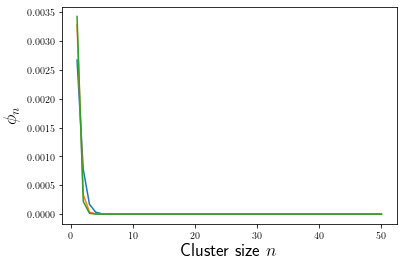

In [72]:
#DILUTE

multip_pst = 0.2
#multip_pst = 10
#multip_pst = 20

p_t = multip_pst*pst


distr_d = sol_d.distr_fin(p_t, kT)

##########################################
#Check that exact and approx are the same
##########################################

# distr_ex = sol_d.distr_exact(p_t, kT)


# plt.plot(np.arange(1, len(distr_ex)+1), distr_ex)
# plt.plot(np.arange(1, len(distr_ex)+1), distr_d[0], '--')
# plt.show()

print(p_t)

for dis in distr_d:
    plt.plot(np.arange(1, len(dis)+1), dis)

plt.xlabel(r'Cluster size $n$', fontsize = font_s)
plt.ylabel(r'$\phi_n$', fontsize = font_s)
plt.show()

0.1831563888873418
1 -dimensions, phi_tot visible :  0.18315600348020808
2 -dimensions, phi_tot visible :  0.04521547773301484
3 -dimensions, phi_tot visible :  0.02799311284002474


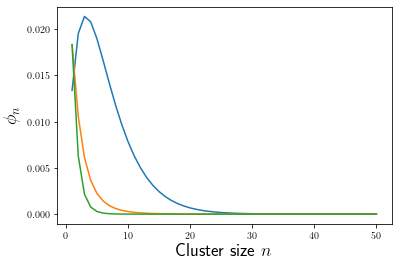

In [59]:
#
#TRY TO DISPLAY THE FIRST M ENTRIES OF DISTRIBUTIONS 
# CORRESPONDING TO THE LIMIT M->INFTY
#

multip_pst = 10


p_t = multip_pst*pst

distr_d_infi = sol_d.distr_infin(p_t, kT)

##########################################
#Check that exact and approx are the same
##########################################

# distr_ex = sol_d.distr_exact(p_t, kT)


# plt.plot(np.arange(1, len(distr_ex)+1), distr_ex)
# plt.plot(np.arange(1, len(distr_ex)+1), distr_d_infi[0], '--')
# plt.show()

print(p_t)

for i, dis in enumerate(distr_d_infi):
    plt.plot(np.arange(1, len(dis)+1), dis)
    print(i+1,'-dimensions, phi_tot visible : ', np.sum(dis))

plt.xlabel(r'Cluster size $n$', fontsize = font_s)
plt.ylabel(r'$\phi_n$', fontsize = font_s)
plt.show()

# Monomers

In [12]:
#MAX AGGREGATE SIZE 
M = 50

d = 1
#DIMENSION OF THE AGGREGATES


ki = 1.


######## POTENTIAL ALTERNATIVE #########
r=1
kT_range = np.linspace(0.1, .7, 1000)

alpha= -.5
beta = -2.


#phi_grid_min, n_grid_points, phi_min, n_points = 1e-7, 1*1e3, 1e-6, 100
phi_grid_min, n_grid_points, phi_min, n_points = 1e-7, 1*1e3, 1e-6, 1000

#WARNING, PHI_MIN SHOULD BE ALWAYS GREATER THAN e^-log_precision
plot_param = np.array([phi_grid_min, n_grid_points, phi_min, n_points])

phi_mic_arr = []
results_arr = []

comp = 'MON'
#comp = 'SIZE'

solver = ph_di( kT_range, r, ki, alpha, beta, M, d, plot_param, comp = comp, plots=0)

results_mono = solver.phase_diagram_mono()

phi_mic =  calc_phi_star(alpha, beta, kT_range) 

kT_range_subs = np.linspace(.15, .55, 3)

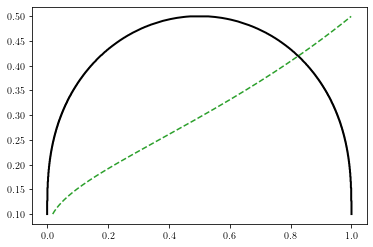

In [ ]:
plt.plot(phi_mic[phi_mic<1], kT_range[phi_mic<1], '--C2', label = r'$\phi^*_\mathrm{sol}$', zorder=3)
border = 0.05
plt.xlim(-border,1+border)

temp_mono = np.append(results_mono[0], np.flipud(results_mono[0]))
phi_mono = np.append(results_mono[1], np.flipud(results_mono[2]))

plt.plot(phi_mono, temp_mono, 'k', lw = 2, label = 'Monomers')



x_lab = r" Total Volume Fraction: $\phi_{\text{tot}}$"
y_lab = r'Temperature: $T$'



plt.show()

# PD i : 1d phases

In [ ]:
M = 50
d = 1

#DIMENSION OF THE AGGREGATES
ki = 1.


r=1
kT_range = np.linspace(0.15, .7, 1000)
#alpha= -1.
alpha= -0.5
beta = -2.

phi_grid_min, n_grid_points, phi_min, n_points = 1e-7, 1e4, 1e-6, 2000




plot_param = np.array([phi_grid_min, n_grid_points, phi_min, n_points])

solver = ph_di_Minfty( kT_range, r, ki, alpha, beta, M, d, plot_param)
results= solver.phase_diagram()

phi_mic =  calc_phi_star(alpha, beta, kT_range)

phi_trans = phi_mic*math.e/np.power( 1-math.e, 2)

x1 = phi_trans[phi_trans<1]
y1 = kT_range[phi_trans<1]

x2 = results[3]
y2 = results[0]

sol = intersection(x1, y1, x2, y2)

pt_sol = sol[0].squeeze()
kT_sol = sol[1].squeeze()

ind_dashed = phi_trans<pt_sol
ind_solid = np.logical_and(phi_trans>pt_sol, phi_trans<1.05)

phi_dashed = np.copy(phi_trans)
phi_dashed[np.logical_not(ind_dashed)] = np.NaN
phi_solid = np.copy(phi_trans)
phi_solid[np.logical_not(ind_solid)] = np.NaN

print('interception point: p =',pt_sol,' kT =' ,kT_sol )

arg_sol = np.nanargmin(np.abs(kT_sol-kT_range))

interception point: p = 0.8621619833725712  kT = 0.46919179730803223


In [137]:
pt = 0.35
kT_homo = 0.675
kT_mono = 0.5
kT_agg = 0.2

kT_homo_2 = 0.4
pt_2 = 0.99

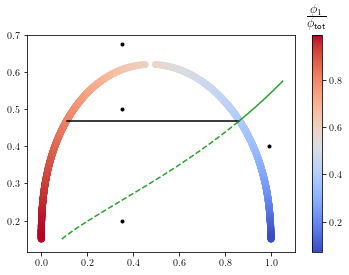

In [ ]:
temp_ex = np.append(results[0], np.flipud(results[0]))
phi_ex = np.append(results[1], np.flipud(results[3]))
comp_ex = np.append(results[2], np.flipud(results[4]))

#plt.plot(phi_mic, kT_range, 'k')

plt.plot(phi_dashed, kT_range, '--C2', zorder=3)
plt.plot(phi_solid, kT_range, '-C2', zorder=3)

plt.plot([results[1][arg_sol], results[3][arg_sol] ], [kT_sol,kT_sol], c='k' )
plt.plot(np.ones(3)*pt, [kT_homo,kT_mono, kT_agg], '.k' )


plt.plot(pt_2, kT_homo_2, '.k' )

plt.scatter(phi_ex, temp_ex, c=comp_ex, cmap = 'coolwarm', label = 'Binodal')
cb = plt.colorbar()
#cb.ax.set_title(r" $ <n \, \phi_n>$", fontsize=18)
cb.ax.set_title(r" $ \frac{\phi_1}{\phi_{\text{tot}}}$", fontsize=18)


x_lab = r" Total Volume Fraction: $\phi_{\text{tot}}$"
y_lab = r'Temperature: $T$'




plt.show()

0.5001501501501501
0.2001001001001001


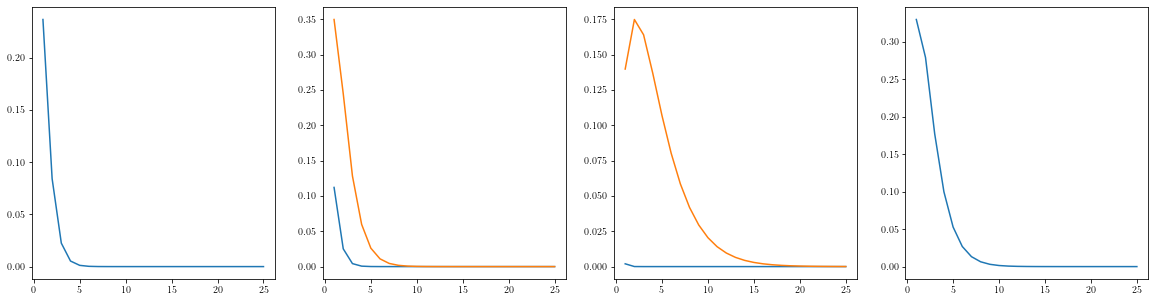

In [ ]:

M=25

n_arr = np.arange(1,M+1)

kT_homo = kT_range[-1]

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20, 5))


n_grid_points = 1e3
sol_d=distr_generator(ki, alpha, beta, M, n_grid_points)

distr_d = sol_d.distr_fin(pt, kT_homo)

p_n_arr_1 = distr_d[0]

ax1.plot( n_arr, p_n_arr_1)

distr_d = sol_d.distr_fin(pt_2, kT_homo_2)

p_n_arr_2 = distr_d[0]

ax4.plot( n_arr, p_n_arr_2)

np.savetxt('../results/pd_i_linear/homo_alp_'+str(alpha)+'_bet_'+str(beta)+'_d_1.txt', 
           (p_n_arr_1, p_n_arr_2) )



ind_T = np.nanargmin(np.abs(kT_range-kT_mono))
print(kT_range[ind_T])

phi_t_out = results[1,ind_T]
phi_mon_out = results[2,ind_T]*results[1,ind_T]
p_n_arr_out = solver.calc_p_n(phi_mon_out, results[0,ind_T], n_arr)

phi_t_in = results[3,ind_T]
phi_mon_in = results[4,ind_T]*results[3,ind_T]

p_n_arr_in = solver.calc_p_n(phi_mon_in,results[0,ind_T], n_arr)
ax2.plot( n_arr, p_n_arr_out, n_arr, p_n_arr_in )



np.savetxt('../results/pd_i_linear/in_out_mono_alp_'+str(alpha)+'_bet_'+str(beta)+'_d_1.txt', 
           (p_n_arr_out, p_n_arr_in) )


ind_T = np.nanargmin(np.abs(kT_range-kT_agg))
print(kT_range[ind_T])

phi_t_out = results[1,ind_T]
phi_mon_out = results[2,ind_T]*results[1,ind_T]
p_n_arr_out = solver.calc_p_n(phi_mon_out, results[0,ind_T], n_arr)

phi_t_in = results[3,ind_T]
phi_mon_in = results[4,ind_T]*results[3,ind_T]

p_n_arr_in = solver.calc_p_n(phi_mon_in,results[0,ind_T], n_arr)
ax3.plot( n_arr, p_n_arr_out, n_arr, p_n_arr_in )

plt.show()


# PS on assembly

In [31]:
M=50
n_arr = np.arange(1,M+1)


alpha= -.5
beta = -2.

n_pt = 500

kT_arr=np.array([0.2, 0.3, 0.4, 0.5 ])

n_grid_points = 1e3
sol_d=distr_generator(ki, alpha, beta, M, n_grid_points)

pt_arr = np.zeros((len(kT_arr), n_pt))
v_arr = np.zeros((len(kT_arr), n_pt))
dist_arr = np.zeros((len(kT_arr), n_pt))

for i, kT_dist in enumerate(kT_arr):

    ind_T = np.nanargmin(np.abs(kT_range-kT_dist))

    phi_t_out = results[1,ind_T]
    phi_mon_out = results[2,ind_T]*results[1,ind_T]
    p_n_arr_out = solver.calc_p_n(phi_mon_out, results[0,ind_T], n_arr)

    phi_t_in = results[3,ind_T]
    phi_mon_in = results[4,ind_T]*results[3,ind_T]

    p_n_arr_in = solver.calc_p_n(phi_mon_in,results[0,ind_T], n_arr)

    border = 0

    pt_fixedT = np.linspace(phi_t_out+border, phi_t_in-border, n_pt)
    pt_arr[i] = pt_fixedT
    
    for j, p in enumerate(pt_fixedT):
        distr_d = sol_d.distr_fin(p, kT_dist)
        p_n_homo = distr_d[0]

        v_drop = (p - phi_t_out)/(phi_t_in-phi_t_out)
        p_n_drop = p_n_arr_out*(1-v_drop) + v_drop*p_n_arr_in

        v_arr[i,j] = v_drop
        dist_arr[i,j] = np.max(np.abs( p_n_homo/np.sum(p_n_homo)-p_n_drop/np.sum(p_n_drop) ))


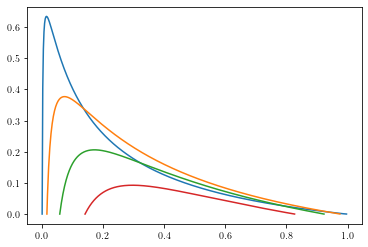

In [32]:
for i, pt in enumerate(pt_arr):
    plt.plot(pt, dist_arr[i])

0.015945814280887937
pt homo dist:  0.015945813518394907
Should be T_1 0.2001001001001001
pt PS:  0.01594465149775237 for the first plot
pt PS with agg:  0.499958471654695 second plot


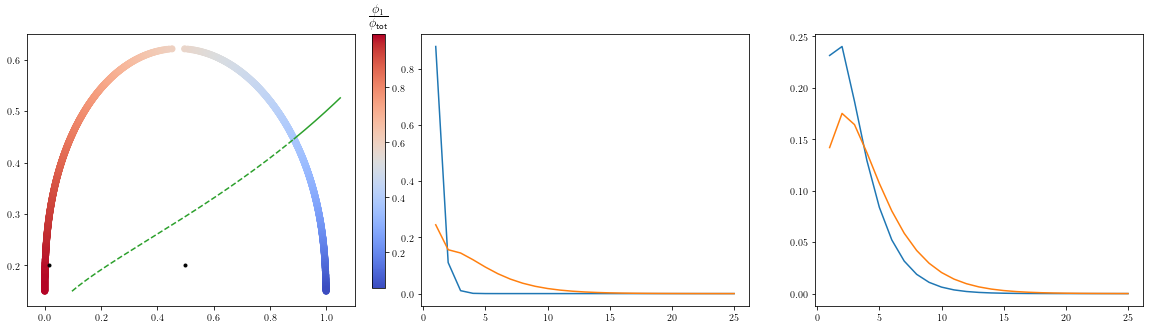

In [ ]:
arg = np.argmax(dist_arr[0])

pt_snap1 = 0.3
kT_snap1 = 0.2

print(pt_arr[0,arg])
pt_snap1 = pt_arr[0,arg]
kT_snap1 = 0.2

pt_snap2 = 0.5
kT_snap2 = 0.2

M=25
n_arr = np.arange(1,M+1)

kT_homo = kT_range[-1]

fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(20, 5))



ax0.plot(phi_dashed, kT_range, '--C2', zorder=3)
ax0.plot(phi_solid, kT_range, '-C2', zorder=3)


ax0.plot([pt_snap1, pt_snap2], [kT_snap1, kT_snap2], '.k' )

pos = ax0.get_position()
x0, y0, x1, y1, w, h = pos.x0, pos.y0, pos.x1, pos.y1,  pos.width, pos.height
im=ax0.scatter(phi_ex, temp_ex, c=comp_ex, cmap = 'coolwarm', label = 'Binodal')

cbar_ax = fig.add_axes([x1 + w/20, y0+h/15 , w/25, h- h/15])
cb = fig.colorbar(im, cax=cbar_ax)

cb.ax.set_title(r" $ \frac{\phi_1}{\phi_{\text{tot}}}$", fontsize=18)






n_grid_points = 1e3
sol_d=distr_generator(ki, alpha, beta, M, n_grid_points)

distr_d = sol_d.distr_fin(pt_snap1, kT_snap1)

p_n_arr_1 = distr_d[0]

print('pt homo dist: ', np.sum(p_n_arr_1))
ax1.plot( n_arr, p_n_arr_1/np.sum(p_n_arr_1))




ind_T = np.nanargmin(np.abs(kT_range-kT_snap1))
print('Should be T_1',kT_range[ind_T])

phi_t_out = results[1,ind_T]
phi_mon_out = results[2,ind_T]*results[1,ind_T]
p_n_arr_out = solver.calc_p_n(phi_mon_out, results[0,ind_T], n_arr)

phi_t_in = results[3,ind_T]
phi_mon_in = results[4,ind_T]*results[3,ind_T]

p_n_arr_in = solver.calc_p_n(phi_mon_in,results[0,ind_T], n_arr)

v_1 = (pt_snap1 - phi_t_out)/(phi_t_in-phi_t_out)

p_n_drop_1 = p_n_arr_out*(1-v_1) + v_1*p_n_arr_in
print('pt PS: ', np.sum(p_n_drop_1), 'for the first plot')

ax1.plot( n_arr, p_n_drop_1/np.sum(p_n_drop_1) )



distr_d = sol_d.distr_fin(pt_snap2, kT_snap2)

p_n_arr_2 = distr_d[0]

ax2.plot( n_arr, p_n_arr_2/np.sum(p_n_arr_2))


ind_T = np.nanargmin(np.abs(kT_range-kT_snap2))


phi_t_out = results[1,ind_T]
phi_mon_out = results[2,ind_T]*results[1,ind_T]
p_n_arr_out = solver.calc_p_n(phi_mon_out, results[0,ind_T], n_arr)

phi_t_in = results[3,ind_T]
phi_mon_in = results[4,ind_T]*results[3,ind_T]

p_n_arr_in = solver.calc_p_n(phi_mon_in,results[0,ind_T], n_arr)

v_2 = (pt_snap2 - phi_t_out)/(phi_t_in-phi_t_out)
p_n_drop_2 = p_n_arr_out*(1-v_2) + v_2*p_n_arr_in

ax2.plot( n_arr, p_n_drop_2/np.sum(p_n_drop_2) )

print('pt PS with agg: ', np.sum(p_n_drop_2), 'second plot')

# PD ii : 1d aggregates

In [ ]:
M = 50
d = 1

#DIMENSION OF THE AGGREGATES
ki = 1.


r=1
kT_range = np.linspace(0.8, 1.1, 1000)
alpha= -5
#alpha= -3
beta = -2
phi_grid_min, n_grid_points, phi_min, n_points = 1e-8, 1e4, 1e-7, 2000





plot_param = np.array([phi_grid_min, n_grid_points, phi_min, n_points])

solver = ph_di_Minfty( kT_range, r, ki, alpha, beta, M, d, plot_param)
results= solver.phase_diagram()

phi_mic =  calc_phi_star(alpha, beta, kT_range)

#i_max = 1
#phi_trans = phi_mic * np.power(1/math.e, 1/i_max)/np.power(1-np.power(1/math.e, 1/i_max),2)
#phi_trans = phi_mic

phi_trans = phi_mic*math.e/np.power( 1-math.e, 2)

x1 = phi_trans[phi_trans<1]
y1 = kT_range[phi_trans<1]

x2 = results[1]
y2 = results[0]


In [ ]:
kT_line = 1.
pt_h1 = 0.001
pt_h2 = 0.05
pt_h3 = 0.075
pt_h4 = 0.1
pt_h5 = 0.3


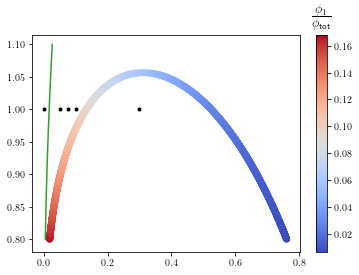

In [ ]:
temp_ex = np.append(results[0], np.flipud(results[0]))
phi_ex = np.append(results[1], np.flipud(results[3]))
comp_ex = np.append(results[2], np.flipud(results[4]))

plt.plot(phi_trans, kT_range, '-C2')


plt.plot([pt_h1, pt_h2, pt_h3, pt_h4, pt_h5], np.ones(5)*kT_line, '.k' )


plt.scatter(phi_ex, temp_ex, c=comp_ex, cmap = 'coolwarm', label = 'Binodal')
cb = plt.colorbar()

cb.ax.set_title(r" $ \frac{\phi_1}{\phi_{\text{tot}}}$", fontsize=18)


x_lab = r" Total Volume Fraction: $\phi_{\text{tot}}$"
y_lab = r'Temperature: $T$'


#plt.xlim(0,0.01)

plt.show()

1.0


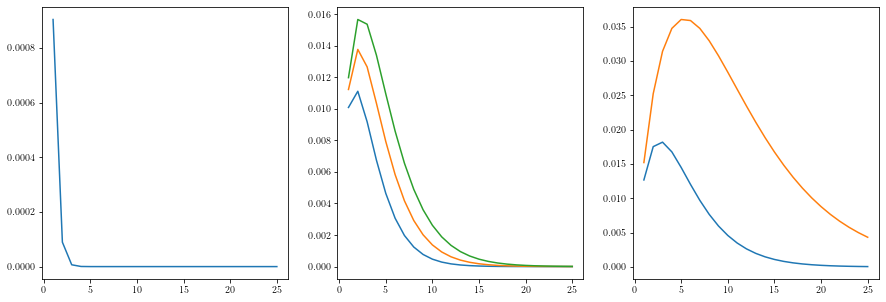

In [68]:
M=25
n_arr = np.arange(1,M+1)


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 5))


n_grid_points = 1e3
sol_d=distr_generator(ki, alpha, beta, M, n_grid_points)

distr_d = sol_d.distr_fin(pt_h1, kT_line)

p_n_arr = distr_d[0]

ax1.plot( n_arr, p_n_arr)



distr_d = sol_d.distr_fin(pt_h2, kT_line)
p_n_arr_2 = distr_d[0]


distr_d = sol_d.distr_fin(pt_h3, kT_line)
p_n_arr_3 = distr_d[0]

distr_d = sol_d.distr_fin(pt_h4, kT_line)
p_n_arr_4 = distr_d[0]


ax2.plot( n_arr, p_n_arr_2)
ax2.plot( n_arr, p_n_arr_3)
ax2.plot( n_arr, p_n_arr_4)


np.savetxt('../results/pd_ii_aggre/homo_pt_'+str(pt)+'_kT_'+str(kT_mono)+'_alp_'+str(alpha)+'_bet_'+str(beta)+'_d_1.txt', 
           (p_n_arr, p_n_arr_2, p_n_arr_3, p_n_arr_4  ) )


ind_T = np.nanargmin(np.abs(kT_range-kT_line))
print(kT_range[ind_T])

phi_t_out = results[1,ind_T]
phi_mon_out = results[2,ind_T]*results[1,ind_T]
p_n_arr_out = solver.calc_p_n(phi_mon_out, results[0,ind_T], n_arr)

phi_t_in = results[3,ind_T]
phi_mon_in = results[4,ind_T]*results[3,ind_T]

p_n_arr_in = solver.calc_p_n(phi_mon_in,results[0,ind_T], n_arr)
ax3.plot( n_arr, p_n_arr_out, n_arr, p_n_arr_in )

# ax1.set_yscale('log')
# ax2.set_yscale('log')
# ax3.set_yscale('log')
plt.show()

np.savetxt('../results/pd_ii_aggre/in_out_agg_pt_'+str(pt)+'_kT_'+str(kT_agg)+'_alp_'+str(alpha)+'_bet_'+str(beta)+'_d_1.txt', 
           (p_n_arr_out, p_n_arr_in) )

np.savetxt('../results/pd_ii_aggre/pt_kT_vals_alp_'+str(alpha)+'_bet_'+str(beta)+'_d_1.txt', 
           (pt_h1, pt_h2, pt_h3, pt_h4, pt_h5, kT_line) )


## TO COMPARE WITH MONOMER ONLY

In [ ]:
M = 50
d = 1

#DIMENSION OF THE AGGREGATES
ki = 1.


r=1
kT_range = np.linspace(0.6, 1.1, 1000)
alpha= -5
beta = -2
phi_grid_min, n_grid_points, phi_min, n_points = 1e-9, 1e4, 1e-9, 2000



plot_param = np.array([phi_grid_min, n_grid_points, phi_min, n_points])

solver = ph_di_Minfty( kT_range, r, ki, alpha, beta, M, d, plot_param)
results= solver.phase_diagram()

phi_mic =  calc_phi_star(alpha, beta, kT_range)

#i_max = 1
#phi_trans = phi_mic * np.power(1/math.e, 1/i_max)/np.power(1-np.power(1/math.e, 1/i_max),2)

phi_trans = phi_mic

x1 = phi_trans[phi_trans<1]
y1 = kT_range[phi_trans<1]

x2 = results[1]
y2 = results[0]


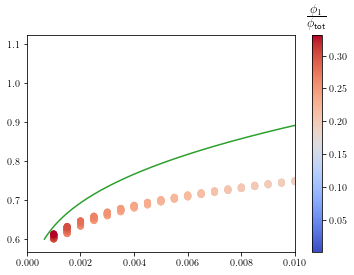

In [ ]:
temp_ex = np.append(results[0], np.flipud(results[0]))
phi_ex = np.append(results[1], np.flipud(results[3]))
comp_ex = np.append(results[2], np.flipud(results[4]))

plt.plot(phi_trans, kT_range, '-C2')




plt.scatter(phi_ex, temp_ex, c=comp_ex, cmap = 'coolwarm', label = 'Binodal')
cb = plt.colorbar()
#cb.ax.set_title(r" $ <n \, \phi_n>$", fontsize=18)
cb.ax.set_title(r" $ \frac{\phi_1}{\phi_{\text{tot}}}$", fontsize=18)


x_lab = r" Total Volume Fraction: $\phi_{\text{tot}}$"
y_lab = r'Temperature: $T$'


plt.xlim(0,0.01)

plt.show()

### PHI STAR VS PHI SAT

In [21]:
#MAX AGGREGATE SIZE 
M = 50

d = 1
#DIMENSION OF THE AGGREGATES


ki = 1.


######## POTENTIAL ALTERNATIVE #########
r=1
kT_chosen = [0.6]

alpha_vals = np.linspace(0, -5., 501)
beta = -2


phi_grid_min, n_grid_points, phi_min, n_points = 1e-8, 1*1e3, 1e-7, 10000
#WARNING, PHI_MIN SHOULD BE ALWAYS GREATER THAN e^-log_precision
plot_param = np.array([phi_grid_min, n_grid_points, phi_min, n_points])

comp_arr = np.zeros_like(alpha_vals)
phi_trans_arr = np.zeros_like(alpha_vals)
phi_sat_arr = np.zeros_like(alpha_vals)

region_arr = np.zeros_like(alpha_vals)

for i, al in enumerate(alpha_vals):
    
    phi_mic =  calc_phi_star(al, beta, kT_chosen[0])
    phi_trans = phi_mic*math.e/np.power( 1-math.e, 2)
    phi_trans_arr[i] = phi_trans
    
    solver = ph_di_Minfty( kT_chosen, r, ki, al, beta, M, d, plot_param, plots=0)

    results = solver.phase_diagram()

    
    if np.any( results ):
        phi_sat_arr[i] = results[1].squeeze() 
        comp_arr[i]= results[2].squeeze() 

        #check if the dense phase has assemblies!
        region_arr[i] = results[3].squeeze() < phi_trans
        
        
    else:
        phi_sat_arr[i] = np.NaN
        comp_arr[i]= np.NaN

        region_arr[i] = np.NaN

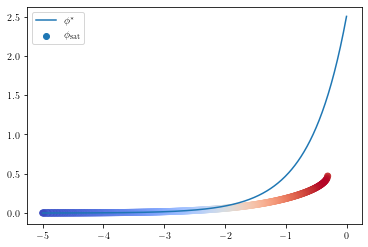

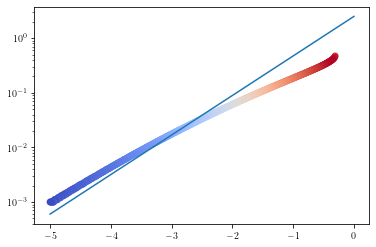

In [23]:
plt.scatter( alpha_vals, phi_sat_arr, c= comp_arr, cmap = 'coolwarm', label = r'$\phi_\mathrm{sat}$')
plt.plot( alpha_vals, phi_trans_arr, label = r'$\phi^*$')
plt.legend()
plt.show()

plt.scatter( alpha_vals, phi_sat_arr, c= comp_arr, cmap = 'coolwarm',label = r'$\phi_\mathrm{sat}$' )
plt.plot( alpha_vals, phi_trans_arr, label = r'$\phi^*$')
plt.yscale('log')
plt.show()

In [176]:
M = 50
d = 1

#DIMENSION OF THE AGGREGATES
ki = 1.


r=1
kT_range = np.linspace(0.6, 1, 100)
alpha= -.5
beta = -2.


phi_grid_min, n_grid_points, phi_min, n_points = 1e-7, 1e4, 1e-6, 2000




plot_param = np.array([phi_grid_min, n_grid_points, phi_min, n_points])

solver = ph_di_Minfty( kT_range, r, ki, alpha, beta, M, d, plot_param)
results= solver.phase_diagram()

phi_mic =  calc_phi_star(alpha, beta, kT_range)

phi_trans = phi_mic*math.e/np.power( 1-math.e, 2)

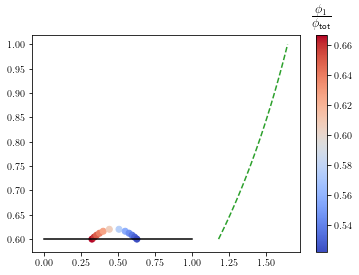

In [177]:
temp_ex = np.append(results[0], np.flipud(results[0]))
phi_ex = np.append(results[1], np.flipud(results[3]))
comp_ex = np.append(results[2], np.flipud(results[4]))

#plt.plot(phi_mic, kT_range, 'k')

plt.plot(phi_mic, kT_range, '--C2', zorder=3)

plt.plot([0,1], [kT_chosen,kT_chosen], 'k' )


plt.scatter(phi_ex, temp_ex, c=comp_ex, cmap = 'coolwarm', label = 'Binodal')
cb = plt.colorbar()
#cb.ax.set_title(r" $ <n \, \phi_n>$", fontsize=18)
cb.ax.set_title(r" $ \frac{\phi_1}{\phi_{\text{tot}}}$", fontsize=18)


x_lab = r" Total Volume Fraction: $\phi_{\text{tot}}$"
y_lab = r'Temperature: $T$'


#make_graph_pretty(x_lab,y_lab)
#plt.ylim(temp_ex[0], np.max(temp_ex))
#plt.xlim(0,0.05)



#plt.legend(fontsize = 12)


plt.show()

In [13]:
om_ratio = 6/4/np.power(4 * math.pi * 9, 1/3)
print(om_ratio)

0.31017524544970004


# gelation

In [ ]:
M = 20
d = 3
#DIMENSION OF THE AGGREGATES

r=1
ki = 1


alpha = -2
beta = -2
kT_range = np.linspace(0.6, 0.8, 350)
phi_grid_min, n_grid_points, phi_min, n_points = 1e-7, 2000, 5e-7, 200


#WARNING, PHI_MIN SHOULD BE ALWAYS GREATER THAN e^-log_precision
plot_param = np.array([phi_grid_min, n_grid_points, phi_min, n_points])

pg = calc_pg_star_ex(alpha, beta, d, kT_range)
#om_ratio = 6/5/np.power(4 * math.pi * 9, 1/3)
om_ratio = 0.5

solver = ph_di_Minfty( kT_range, r, ki, alpha, beta, M, d, plot_param, om_gel=[alpha*om_ratio, beta*om_ratio])


ind_free = 0
res_gel_simple, free, stab_ind = solver.phase_diagram([ind_free])
free = free.squeeze()

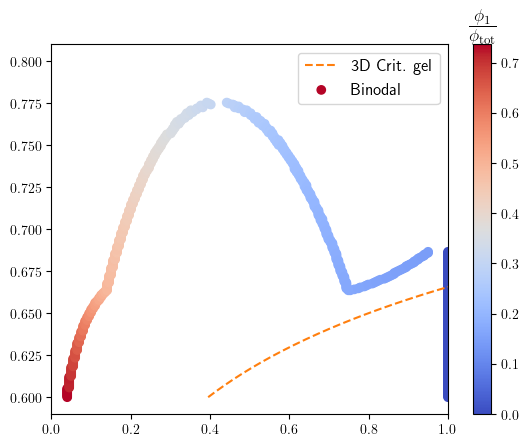

In [17]:
temp = np.append(res_gel_simple[0], np.flipud(res_gel_simple[0]))
phi = np.append(res_gel_simple[1], np.flipud(res_gel_simple[3]))
comp = np.append(res_gel_simple[2], np.flipud(res_gel_simple[4]))

plt.plot(pg, kT_range, '--C1', label = '3D Crit. gel')

plt.scatter(phi, temp, c=comp, cmap = 'coolwarm', label = 'Binodal')
cb = plt.colorbar()
#cb.ax.set_title(r" $ <n \, \phi_n>$", fontsize=18)
cb.ax.set_title(r" $ \frac{\phi_1}{\phi_{\mathrm{tot}}}$", fontsize=18)


x_lab = r" Total Volume Fraction: $\phi_{\mathrm{tot}}$"
y_lab = r'Temperature: $T$'
plt.xlim(0,1)
plt.legend(fontsize = 12)


plt.show()

### Example distributions 

In [29]:
kT_range = np.linspace(0.625, 0.7, 2)

ki = 1

alpha = -2
beta = -2

phi_grid_min, n_grid_points, phi_min, n_points = 1e-7, 2000, 5e-7, 200



#WARNING, PHI_MIN SHOULD BE ALWAYS GREATER THAN e^-log_precision
plot_param = np.array([phi_grid_min, n_grid_points, phi_min, n_points])

pg = calc_pg_star(alpha, beta, d, kT_range)


solver = ph_di_Minfty( kT_range, r, ki, alpha, beta, M, d, plot_param, om_gel=[alpha*om_ratio, beta*om_ratio])
#results= solver.phase_diagram()

results = solver.phase_diagram()

0.7


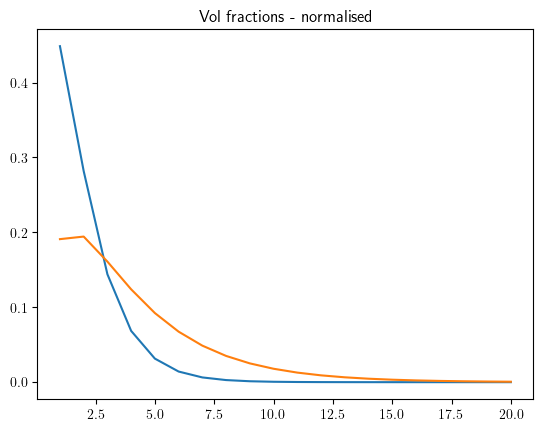

0.625


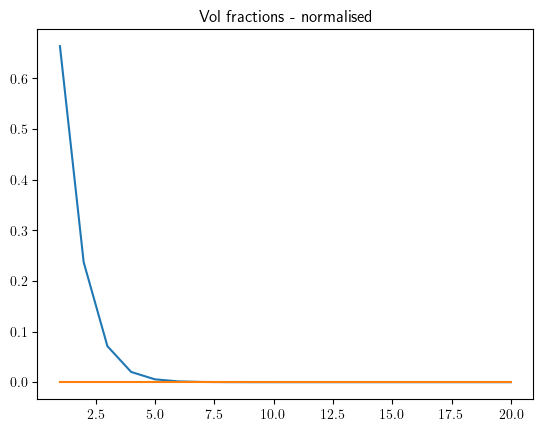

In [ ]:
pt = 0.4

ind_T = -1

n_arr = np.arange(1,M+1)

phi_t_out = results[1,ind_T]
phi_mon_out = results[2,ind_T]*results[1,ind_T]
p_n_arr_out = solver.calc_p_n(phi_mon_out, results[0,ind_T], n_arr)

phi_t_in = results[3,ind_T]
phi_mon_in = results[4,ind_T]*results[3,ind_T]

kT_ss = results[0,ind_T]
print(kT_ss)
p_n_arr_in = solver.calc_p_n(phi_mon_in,results[0,ind_T], n_arr)
plt.plot( n_arr, p_n_arr_out/phi_t_out, n_arr, p_n_arr_in/phi_t_in )

plt.title('Vol fractions - normalised')
plt.show()

np.savetxt('results/pd_gel_simple/in_out_ss_alp_'+str(alpha)+'_bet_'+str(beta)+'_d_3.txt', 
           (p_n_arr_out, p_n_arr_in) )

ind_T = 0

n_arr = np.arange(1,M+1)

phi_t_out = results[1,ind_T]
phi_mon_out = results[2,ind_T]*results[1,ind_T]
p_n_arr_out = solver.calc_p_n(phi_mon_out, results[0,ind_T], n_arr)

phi_t_in = results[3,ind_T]
phi_mon_in = results[4,ind_T]*results[3,ind_T]

kT_sg = results[0,ind_T]
print(kT_sg)

p_n_arr_in = solver.calc_p_n(phi_mon_in,results[0,ind_T], n_arr)
plt.plot( n_arr, p_n_arr_out/phi_t_out, n_arr, p_n_arr_in/phi_t_in )

plt.title('Vol fractions - normalised')
plt.show()



In [49]:
#### SET FOR free
kT_range = np.array([0.625, 0.675, 0.725])

ki = 1

alpha = -2
beta = -2

phi_grid_min, n_grid_points, phi_min, n_points = 1e-7, 700, 5e-7, 500


#WARNING, PHI_MIN SHOULD BE ALWAYS GREATER THAN e^-log_precision
plot_param = np.array([phi_grid_min, n_grid_points, phi_min, n_points])


solver = ph_di_Minfty( kT_range, r, ki, alpha, beta, M, d, plot_param, om_gel=[alpha*om_ratio, beta*om_ratio])
#results= solver.phase_diagram()

ind_free = 2
results, free, stab_ind = solver.phase_diagram([ind_free])
free = free.squeeze()

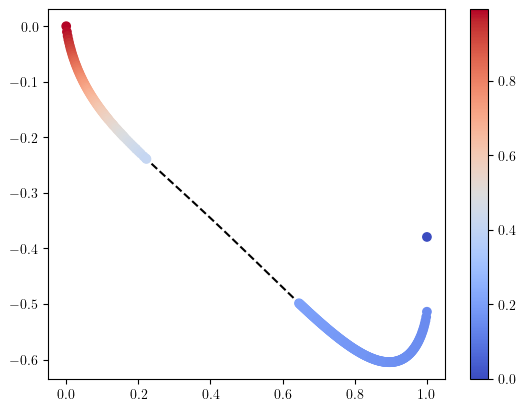

In [50]:
plt.plot(free[0,:-1], free[1,:-1], 'k--')
plt.scatter(free[0,stab_ind], free[1, stab_ind], c=free[2, stab_ind], cmap = 'coolwarm', zorder=3)
cb = plt.colorbar()

plt.show()

# ESTIMATING OMEGA_INFINITY

In [67]:
M = 30
d = 3
#DIMENSION OF THE AGGREGATES

r=1

kT_range = np.linspace(0.64, 0.65, 10)
#kT_range = np.linspace(0.6, 0.8, 250)


ki = 1

alpha = -2
beta = -2

phi_grid_min, n_grid_points, phi_min, n_points = 1e-7, 400, 5e-7, 200
#phi_grid_min, n_grid_points, phi_min, n_points = 1e-7, 500, 5e-7, 200


#WARNING, PHI_MIN SHOULD BE ALWAYS GREATER THAN e^-log_precision
plot_param = np.array([phi_grid_min, n_grid_points, phi_min, n_points])

pg = calc_pg_star_ex(alpha, beta, d, kT_range)
#faktor = 0.4

solver = ph_di_Minfty( kT_range, r, ki, alpha, beta, M, d, plot_param)
#results= solver.phase_diagram()

ind_free = 0
res_gel_simple, free, stab_ind = solver.phase_diagram([ind_free])
free = free.squeeze()

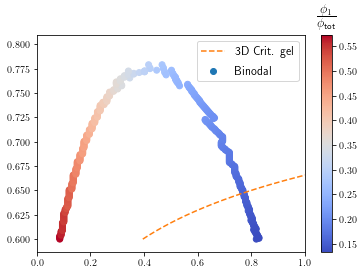

In [68]:
temp = np.append(res_gel_simple[0], np.flipud(res_gel_simple[0]))
phi = np.append(res_gel_simple[1], np.flipud(res_gel_simple[3]))
comp = np.append(res_gel_simple[2], np.flipud(res_gel_simple[4]))

plt.plot(pg, kT_range, '--C1', label = '3D Crit. gel')

plt.scatter(phi, temp, c=comp, cmap = 'coolwarm', label = 'Binodal')
cb = plt.colorbar()
#cb.ax.set_title(r" $ <n \, \phi_n>$", fontsize=18)
cb.ax.set_title(r" $ \frac{\phi_1}{\phi_{\text{tot}}}$", fontsize=18)


x_lab = r" Total Volume Fraction: $\phi_{\text{tot}}$"
y_lab = r'Temperature: $T$'
plt.xlim(0,1)
plt.legend(fontsize = 12)


plt.show()


# im1.set_norm(norm_01)

# plt.plot(free[0,:-1], free[1,:-1], 'k--')
# plt.scatter(free[0,stab_ind], free[1, stab_ind], c=free[2, stab_ind], cmap = 'coolwarm', zorder=3)
# cb = plt.colorbar()

# plt.show()

In [40]:
x1, y1 = pg, kT_range
        
x2, y2 = res_gel_simple[3], res_gel_simple[0]
    

sol = intersection(x1, y1, x2, y2)

phi_three, kT_three = np.squeeze(sol)

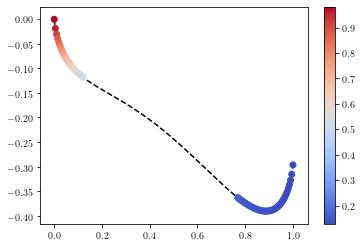

In [41]:
solver = ph_di_Minfty( [kT_three], r, ki, alpha, beta, M, d, plot_param)
#results= solver.phase_diagram()

ind_free = 0
res_three, free, stab_ind = solver.phase_diagram([ind_free])
free = free.squeeze()


plt.plot(free[0], free[1], 'k--')
plt.scatter(free[0,stab_ind], free[1, stab_ind], c=free[2, stab_ind], cmap = 'coolwarm', zorder=3)
cb = plt.colorbar()

plt.show()

In [42]:
phi_t_s =  free[0, stab_ind].squeeze()
f_t_s = free[1, stab_ind].squeeze() 

#Sort Stable points 
args=np.argsort(phi_t_s)
phi_t_ss = phi_t_s[args]
f_t_ss = f_t_s[args]

diff_indices=abs(phi_t_ss[1:]-phi_t_ss[:-1])
amax = np.argmax(diff_indices)



x1 = phi_t_ss[amax]
x2 = phi_t_ss[amax+1]

y1 = f_t_s[amax]
y2 = f_t_s[amax+1]


m = (y2-y1)/(x2-x1)

b = y1 - m*x1

free_three = m*1+b

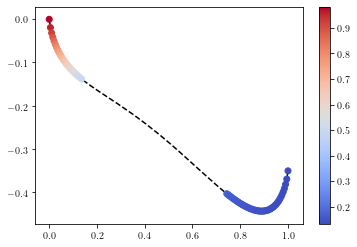

In [43]:
kT_range = np.linspace(0.64, 0.8, 500)

pg = calc_pg_star_ex(alpha, beta, d, kT_range)

x1, y1 = pg, kT_range
        
x2, y2 = np.ones_like(kT_range), kT_range
    

sol = intersection(x1, y1, x2, y2)

phi_top, kT_top = np.squeeze(sol)

solver = ph_di_Minfty( [kT_top], r, ki, alpha, beta, M, d, plot_param)
#results= solver.phase_diagram()

ind_free = 0
res_three, free, stab_ind = solver.phase_diagram([ind_free])
free = free.squeeze()

plt.plot(free[0], free[1], 'k--')
plt.scatter(free[0,stab_ind], free[1, stab_ind], c=free[2, stab_ind], cmap = 'coolwarm', zorder=3)
cb = plt.colorbar()

free_top = free[1, (stab_ind.squeeze() )[-1]]


plt.show()

In [44]:
alpha_gel = (free_three - free_top)/(1/kT_three - 1/kT_top)
beta_gel =  alpha_gel/kT_three - free_three

print(alpha_gel, beta_gel)

-2.3516936647683875 -3.181698279415514


In [27]:
M = 25
d = 3
#DIMENSION OF THE AGGREGATES

r=1

kT_range = np.linspace(0.6, 0.8, 250)
#kT_range = np.linspace(0.6, 0.8, 25)


ki = 1

alpha = -2
beta = -2

phi_grid_min, n_grid_points, phi_min, n_points = 1e-7, 2000, 5e-7, 1000
#phi_grid_min, n_grid_points, phi_min, n_points = 1e-7, 200, 5e-7, 100



#WARNING, PHI_MIN SHOULD BE ALWAYS GREATER THAN e^-log_precision
plot_param = np.array([phi_grid_min, n_grid_points, phi_min, n_points])

pg = calc_pg_star(alpha, beta, d, kT_range)


solver = ph_di_Minfty( kT_range, r, ki, alpha, beta, M, d, plot_param, om_gel=[alpha_gel, beta_gel])
#results= solver.phase_diagram()

results = solver.phase_diagram()

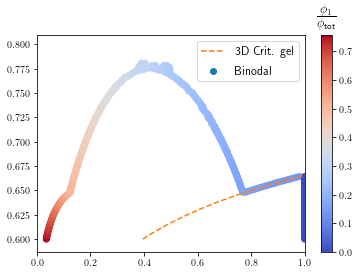

In [28]:
temp = np.append(results[0], np.flipud(results[0]))
phi = np.append(results[1], np.flipud(results[3]))
comp = np.append(results[2], np.flipud(results[4]))

plt.plot(pg, kT_range, '--C1', label = '3D Crit. gel')

plt.scatter(phi, temp, c=comp, cmap = 'coolwarm', label = 'Binodal')
cb = plt.colorbar()
#cb.ax.set_title(r" $ <n \, \phi_n>$", fontsize=18)
cb.ax.set_title(r" $ \frac{\phi_1}{\phi_{\text{tot}}}$", fontsize=18)


x_lab = r" Total Volume Fraction: $\phi_{\text{tot}}$"
y_lab = r'Temperature: $T$'


#make_graph_pretty(x_lab,y_lab)
#plt.ylim(temp[0], np.max(temp))
plt.xlim(0,1)



plt.legend(fontsize = 12)


plt.show()

## Assembly on PS

In [45]:
#MAX AGGREGATE SIZE 
M = 50

d = 1
#DIMENSION OF THE AGGREGATES


ki = 1.


######## POTENTIAL ALTERNATIVE #########
r=1
kT_range = np.linspace(0.2, .85, 2000)

#alpha_vals = np.array([ .5, -1., -2.])
alpha_vals = np.array([ 0, -1., -2.])
beta = -2


phi_grid_min, n_grid_points, phi_min, n_points = 1e-7, 1*1e3, 1e-6, 2000
#WARNING, PHI_MIN SHOULD BE ALWAYS GREATER THAN e^-log_precision
plot_param = np.array([phi_grid_min, n_grid_points, phi_min, n_points])

phi_mic_arr = []
results_arr = []

for i, al in enumerate(alpha_vals):
    solver = ph_di_Minfty( kT_range, r, ki, al, beta, M, d, plot_param, plots=0)

    if i ==0:
        res_mon = solver.phase_diagram_mono()

    phi_mic_arr.append( calc_phi_star(al, beta, kT_range) )
    results_arr.append( solver.phase_diagram()  )

In [46]:
temp_mono = np.append(res_mon[0], np.flipud(res_mon[0]))
phi_mono = np.append(res_mon[1], np.flipud(res_mon[2]))

temp_ex = np.zeros((len(alpha_vals),2*len(kT_range)))
temp_ex[:] = np.nan
phi_ex = np.copy(temp_ex)
comp_ex = np.copy(temp_ex)

for i, results_exact in enumerate(results_arr):
    
    le = 2*len(results_exact[0])
    
    temp_ex[i,:le] = np.append(results_exact[0], np.flipud(results_exact[0]))
    phi_ex[i, :le] = np.append(results_exact[1], np.flipud(results_exact[3]))
    comp_ex[i, :le] = np.append(results_exact[2], np.flipud(results_exact[4]))

    
res_agg = results_arr[0]

pt_equi0 = np.zeros_like(res_mon[1])

for i in range(len(res_mon[1])):
    pt_equi0[i] = ( (res_mon[1,i]*(res_agg[3,i] - res_agg[1,i]) -  res_agg[1,i]*(res_mon[2,i] - res_mon[1,i]) )/
                   (res_agg[3,i] - res_mon[2,i] - (res_agg[1,i] - res_mon[1,i]))  )


res_agg = results_arr[1]

pt_equi1 = np.zeros_like(res_mon[1])

for i in range(len(res_mon[1])):
    pt_equi1[i] = ( (res_mon[1,i]*(res_agg[3,i] - res_agg[1,i]) -  res_agg[1,i]*(res_mon[2,i] - res_mon[1,i]) )/
                   (res_agg[3,i] - res_mon[2,i] - (res_agg[1,i] - res_mon[1,i]))  )

res_agg = results_arr[2]
pt_equi2 = np.zeros_like(res_mon[2])

for i in range(len(res_mon[1])):
    pt_equi2[i] = ( (res_mon[1,i]*(res_agg[3,i] - res_agg[1,i]) -  res_agg[1,i]*(res_mon[2,i] - res_mon[1,i]) )/
                   (res_agg[3,i] - res_mon[2,i] - (res_agg[1,i] - res_mon[1,i]))  )

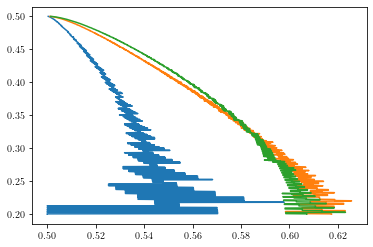

In [48]:
plt.plot(pt_equi0, res_mon[0])
plt.plot(pt_equi1, res_mon[0])
plt.plot(pt_equi2, res_mon[0])

plt.show()

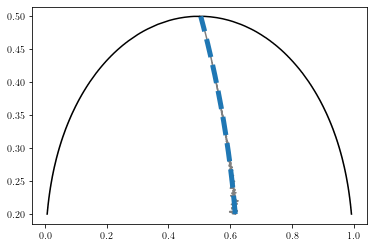

In [50]:
def objective(x, a, b, c):
    return a * x**2 + b * x + c

##### USING THE E_INT =-1
params_fit, _ = curve_fit(objective, res_mon[0], pt_equi1)
a,b,c = params_fit

 
y_fit = res_mon[0]
x_fit = objective(res_mon[0], a, b, c)

# args = np.logical_and(y_fit> res_mon[0][0] , y_fit< res_mon[0][-1] )
# x_fit = pt_equi[args]
# y_fit = y_fit[args]


plt.plot(phi_mono, temp_mono, 'k', label = 'Monomers')
plt.plot(pt_equi1, res_mon[0], 'k', alpha = 0.5)

plt.plot(x_fit, y_fit, '--', lw = 5)

plt.show()

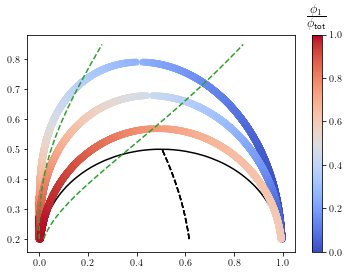

In [51]:
border = 0.05
plt.xlim(-border,1+border)

plt.plot(phi_mono, temp_mono, 'k', label = 'Monomers')

for i, p in enumerate(phi_ex):
    
    pm = phi_mic_arr[i]
    
    args = pm<1
    plt.plot(pm[args], kT_range[args], '--C2', label = r'$\phi^*_\mathrm{sol}$'+str(alpha_vals[i]), zorder=3)
    plt.plot(x_fit, y_fit, 'k--')


    im = plt.scatter(p, temp_ex[i], c=comp_ex[i], cmap = 'coolwarm', label = r'$e_\mathrm{int}$ = '+str(alpha_vals[i]), zorder = 3-i)
    im.set_norm(norm_01)
    
cb = plt.colorbar(im)
#cb.ax.set_title(r" $ <n \, \phi_n>$", fontsize=18)
cb.ax.set_title(r" $ \frac{\phi_1}{\phi_{\text{tot}}}$", fontsize=18)


x_lab = r" Total Volume Fraction: $\phi_{\text{tot}}$"
y_lab = r'Temperature: $T$'




#plt.legend(fontsize = 12)


plt.show()

In [141]:
#MAX AGGREGATE SIZE 
M = 50

d = 1
#DIMENSION OF THE AGGREGATES


ki = 1.


######## POTENTIAL ALTERNATIVE #########
r=1
kT_range = np.linspace(0.495, 1.25, 500)

alpha_arr = np.linspace( -5, 1.5, 51)
beta = -2


phi_grid_min, n_grid_points, phi_min, n_points = 1e-7, 1*1e3, 1e-6, 1000
#WARNING, PHI_MIN SHOULD BE ALWAYS GREATER THAN e^-log_precision
plot_param = np.array([phi_grid_min, n_grid_points, phi_min, n_points])

kT_crit = np.zeros_like(alpha_arr)
phi_crit = np.zeros_like(alpha_arr)


for i, al in enumerate(alpha_arr):
    solver = ph_di( kT_range, r, ki, al, beta, M, d, plot_param, plots=0)

    if i ==0:
        results_mono = solver.phase_diagram_mono()
    
    results = solver.phase_diagram_exact() 
    kT_crit[i] = np.max(results[0])
    phi_crit[i] = (results[1,-1] + results[3,-1])/2

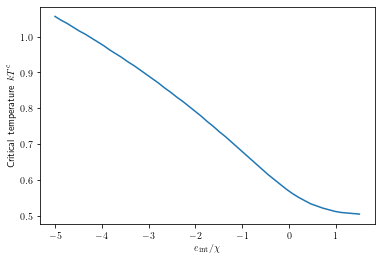

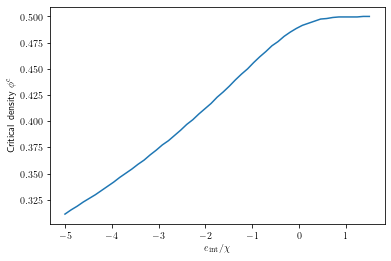

In [142]:
plt.plot( alpha_arr, kT_crit)
plt.xlabel(r'$e_\mathrm{int}/\chi$')
plt.ylabel(r'Critical temperature $kT^\mathrm{c}$ ')
plt.show()


plt.plot( alpha_arr, phi_crit)

plt.xlabel(r'$e_\mathrm{int}/\chi$')
plt.ylabel(r'Critical density $\phi^\mathrm{c}$ ')
plt.show()